###  <span style="color:red">**This Notebook can be run from Google Colab:**</span>

https://colab.research.google.com

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile
import shutil
from google.colab import files
import json
import time
import pandas as pd

import keras
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,\
                          Conv2D, MaxPooling2D, Flatten, AveragePooling2D,\
                          GlobalAveragePooling2D, ZeroPadding2D
from keras.initializers import glorot_uniform
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, \
                            classification_report

# Import PyDrive and associated libraries (to connect with GoogleDrive)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# disable warnings
import warnings
warnings.simplefilter("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### **Check if we are using GPU:**

In [0]:
from keras import backend as K
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.15.0 , GPU: /device:GPU:0


### **Download Patches from GoogleDrive:**

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1SM1aFESHTvMJa2bx3X6cd6HAwwYY3gPI' #NEW 128x128_STRIDE_30_no border_minpospix_1250 minposval_1024 Downsampled control ROT_EVERY_45 DOWNSAMPLED_TRAIN-VAL

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
print('Downloaded content: "{}"'.format(downloaded['title']))
print('Root dir content: {}'.format(os.listdir()))

Downloaded content: "Patches_new_128_s60_vs22_min1250_minval_1024_pos_only_no_border_nonNeg_rot_every_45_balanced_train-val.zip"
Root dir content: ['.config', 'Patches', 'base_model (1).h5', 'adc.json', 'base_model.h5', 'history_dict.json', 'Patches_new_128_s60_vs22_min1250_minval_1024_pos_only_no_border_nonNeg_rot_every_45_balanced_train-val.zip', 'sample_data']


### **Unzip the Patches:**

In [0]:
# Remove 'Patches' dir if it already exists
if 'Patches' in os.listdir():
  shutil.rmtree('./Patches')
with zipfile.ZipFile(downloaded['title'],"r") as zip:
    zip.extractall()
os.remove(downloaded['title'])
print('Root dir content: {}'.format(os.listdir()))

Root dir content: ['.config', 'Patches', 'base_model (1).h5', 'adc.json', 'base_model.h5', 'history_dict.json', 'sample_data']


### **Let's count patches by type and location and save class weights in inverse proportion to the number of patches for each class:**

In [0]:
class_weights = {} # empty dictionary to store class weights
classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']

grand_total, pos_total, neg_total = 0, 0, 0
for type in ['Serial', 'Control', 'Streak']:
    print("\nTotal '{}' Patches per location:".format(type))
    n_type, type_pos, type_neg = 0, 0, 0
    class_weights[type] = {} # nested empty dictionary to store class weights
    class_weights[type]['pos'] = {} # nested dictionary to store class weights
    class_weights[type]['neg'] = {} # nested dictionary to store class weights
    for cls in classes:
        pos_folder = './Patches/Positive/{}/{}_pos'.format(type,cls)
        neg_folder = './Patches/Negative/{}/{}_neg'.format(type,cls)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
        class_weights[type]['pos']['{}'.format(cls)] = 1/n_pos if n_pos else 0
        class_weights[type]['neg']['{}'.format(cls)] = 1/n_neg if n_neg else 0
    print('Total {}: {} = {} positive + {} negative'.format(type,n_type,type_pos,type_neg))
    for loc in class_weights[type]['pos'].keys():
        class_weights[type]['pos'][loc] *= type_pos
    for loc in class_weights[type]['neg'].keys():
        class_weights[type]['neg'][loc] *= type_neg
    grand_total += n_type
    pos_total += type_pos
    neg_total += type_neg
print('\nGRAND TOTAL: {} = {} positive + {} negative'.format(grand_total,pos_total,neg_total))


Total 'Serial' Patches per location:
total_C1: 5998 = 5998 positive + 0 negative
total_C2-3: 5998 = 5998 positive + 0 negative
total_C4-7: 5998 = 5998 positive + 0 negative
total_C5: 5998 = 5998 positive + 0 negative
total_C6: 5998 = 5998 positive + 0 negative
total_C8: 5998 = 5998 positive + 0 negative
total_C9: 4100 = 4100 positive + 0 negative
total_C10: 5998 = 5998 positive + 0 negative
Total Serial: 46086 = 46086 positive + 0 negative

Total 'Control' Patches per location:
total_C1: 364 = 364 positive + 0 negative
total_C2-3: 364 = 364 positive + 0 negative
total_C4-7: 364 = 364 positive + 0 negative
total_C5: 364 = 364 positive + 0 negative
total_C6: 364 = 364 positive + 0 negative
total_C8: 364 = 364 positive + 0 negative
total_C9: 364 = 364 positive + 0 negative
total_C10: 364 = 364 positive + 0 negative
Total Control: 2912 = 2912 positive + 0 negative

Total 'Streak' Patches per location:
total_C1: 0 = 0 positive + 0 negative
total_C2-3: 0 = 0 positive + 0 negative
total_C4-7

#### **Let's build image generators, using keras.preprocessing.image.ImageDataGenerator, rescaling image pixel values from [0,  255] to [0, 1]:**

In [0]:
c1_pos_folder = './Patches/Positive/Serial/C1_pos'
img = plt.imread(c1_pos_folder + '/' + os.listdir(c1_pos_folder)[:5][0])
img_size = img.shape
train_batch_size = 32
val_batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

print("For training:")
train_generator = datagen.flow_from_directory(
        './Patches/Positive/Serial',
        target_size=(img_size[0],img_size[1]),
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True)

print("\nFor validation:")
val_generator = val_datagen.flow_from_directory(
        './Patches/Positive/Control',
        target_size=(img_size[0],img_size[1]),
        batch_size=val_batch_size,
        class_mode='categorical',
        shuffle=False)

For training:
Found 46086 images belonging to 8 classes.

For validation:
Found 2912 images belonging to 8 classes.


#### **Let's check what is the train generators' index for each class, so we can correclty set up the class weights:**

In [0]:
print('train_generator.class_indices:', str(json.dumps(train_generator.class_indices, indent=2, default=str)))

train_generator.class_indices: {
  "C10_pos": 0,
  "C1_pos": 1,
  "C2-3_pos": 2,
  "C4-7_pos": 3,
  "C5_pos": 4,
  "C6_pos": 5,
  "C8_pos": 6,
  "C9_pos": 7
}


#### **Let's set up the class weights in correct order:**

In [0]:
serial_pos_weights = [class_weights['Serial']['pos']['C10']] # C10 has index 0
for cls in classes:
    if cls == 'C10': continue
    serial_pos_weights.append(class_weights['Serial']['pos']['{}'.format(cls)])
print('original class weights dictionary:')
print(str(json.dumps(class_weights['Serial']['pos'], indent=2, default=str)))
print('class weights for generator, re-arranging indexes:')
print(str(json.dumps(serial_pos_weights, indent=2, default=str)))

original class weights dictionary:
{
  "C1": 7.683561187062353,
  "C2-3": 7.683561187062353,
  "C4-7": 7.683561187062353,
  "C5": 7.683561187062353,
  "C6": 7.683561187062353,
  "C8": 7.683561187062353,
  "C9": 11.240487804878049,
  "C10": 7.683561187062353
}
class weights for generator, re-arranging indexes:
[
  7.683561187062353,
  7.683561187062353,
  7.683561187062353,
  7.683561187062353,
  7.683561187062353,
  7.683561187062353,
  7.683561187062353,
  11.240487804878049
]


## **Let's build our Base Model. We will use Resnet:**

#### **First. let's create a function to build a residual block.**

#### We will use the residual block proposed in  [ResNetV2](https://arxiv.org/pdf/1603.05027.pdf) and will implement it by ourselves:


>![Google's logo](https://camo.githubusercontent.com/7ae470c333cd76078e1c669055ad98bcedaf523f/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3130303532332f61313536613563322d303236622d646535352d613666622d6534666131373732623432632e706e67)

In [0]:
def res_block(X, filters, kernel_size=(3,3), l2_reg=1e-6, residual=True,
              first=False, subsampling=False):
    """
    Function to build a residual block as proposed in ResNetV2:
             https://arxiv.org/pdf/1603.05027.pdf:
    :param X: The input to the residual block
    :param filters: Integer. Number of filters / channels in the output
    :param kernel_size: Tuple (Int, Int). kernel size for convolution operations
    :param l2_reg: Float. L2 norm for L2 regularization
    :param residual: Boolean. True if residual block. Otherwise 'plain' block.
    :param first: Boolean. True if first residual block -> ZeroPad and Maxpool.
    :param subsampling: Boolean. True if subsampling within the residual block.
    :return: the addition output from the residual block proposed in ResNetV2:
              https://arxiv.org/pdf/1603.05027.pdf
    """
    bn = BatchNormalization()(X)
    relu = Activation("relu")(bn)
    
    if first: #The first layer is subsampled with Maxpool
      pad = ZeroPadding2D(padding=(1, 1))(relu)
      relu = MaxPooling2D(pool_size=(3, 3), strides=(2,2))(pad)    
    
    if subsampling: #Resnet reduces size just by using stride=2 instead of pool
      #Here we will reduce the size (subsample) by using stride 2 
      conv_1 = Conv2D(filters, kernel_size, strides=(2,2), padding='same',
                         kernel_regularizer=regularizers.l2(l2_reg),
                         kernel_initializer = glorot_uniform(0),
                         bias_initializer = glorot_uniform(0))(relu)
      if residual:
        #To be able to add, we also need to reduce size of input
        #For this, we will just use a 1x1 Conv2D with stride 2  
        res = Conv2D(filters, kernel_size=[1,1], strides=(2,2),
                     padding='same')(X)
    else: #No subsampling, same size as input
      conv_1 = Conv2D(filters, kernel_size, strides=(1,1), padding='same',
                   kernel_regularizer=regularizers.l2(l2_reg),
                   kernel_initializer = glorot_uniform(0),
                   bias_initializer = glorot_uniform(0))(relu)
      if residual:
        if first: #The first layer is subsampled with Maxpool so, resize X
          #For this, we will just use a 1x1 Conv2D with stride 2
          res = Conv2D(filters, kernel_size=[1,1], strides=(2,2),
                     padding='same')(X)
        else:
          res = X
    bn = BatchNormalization()(conv_1)
    relu = Activation("relu")(bn)

    conv_2 = Conv2D(filters, kernel_size, padding='same',
                       kernel_regularizer=regularizers.l2(l2_reg),
                       kernel_initializer = glorot_uniform(0),
                       bias_initializer = glorot_uniform(0))(relu)
    if residual:
      add = keras.layers.add([res, conv_2])
      return add
    else:
      return conv_2

#### **Second, let's create a function to build a Resnet network:**

In [0]:
#from keras.layers import AveragePooling2D, GlobalAveragePooling2D

def make_resnet(img_size, n_classes, layers_per_group, n_filters, 
                    kernel_sizes, l2_reg=1e-6, optimizer=keras.optimizers.SGD,
                    lr=1e-1, decay=1e-4, momentum=0.9, residual=True):
  
    """
    Function to build ResNet network, but with some user defined parameters.
        
        ResNet network input size is (224,224,3) then it starts with one 
        convolution layer, (7x7x64, stride 2) followed by maxpool (3x3, stride2) 
        then it will build 4 layer groups and the user will define the number of
        residual layers per group.
        
        As example, ResNet34, after the first convolution layer, it has 4 groups
        of layers with the following number of residual 'layers_per_group':
        [6,8,12,6]
        Because the residual connections are made between pair of layers, the
        number of layers for each group must be a pair number.
        
        The user will also be able to define the number of filters and size of
        each filter, independently for each group of layers. All layers in the
        same group group will have the same number of filters and each filter
        within the group will have the same size.
        
        Same as ResNet, an average pooling layer follows after the 4 groups
        of layers.
    
    :param img_size: Size of input image, in the form: (size, size, #channels)
    :param n_classes: Integer. Number of classes for classification.
    :param layers_per_group: List with # of layers per group (e.g.[6,8,12,6])
    :param n_filters: List of length 4, with number of filters for each group of
                      layers.
    :param kernel_sizes: List of length 4, with kernel sizes tuples for each 
                          group of layers
    :param l2_reg: Float. L2 norm for L2 regularization
    :param optimizer: A keras optimizer from keras.optimizers
    :param lr: Float. learning rate for the optimizer.
    :param decay: Float. learning rate decay for the optimizer.
    :param momentum: Float. Momentum for SGD if optimizer=keras.optimizers.SGD
    :param residual: Boolean. True if residual net. Otherwise 'plain' net.
    :return: CNN with residual connections, similar to ResNet32
    """
    
    if len(layers_per_block) != len(n_filters) or len(layers_per_block) !=\
        len(kernel_sizes) or len(n_filters) != len(n_filters):
        e = "Length of 'layers_per_block', 'n_filters' and 'kernel_sizes'" +\
        " must be the same"
        raise Exception(e)  

    for layers in layers_per_block:
      if layers % 2 == 1:
        e = "Number of 'layers_per_block' must be even/pair numbers"
        raise Exception(e)
      
    inputs = Input(shape=img_size)
    
    n_filters_conv1 = 64
    kernel_sizes_conv1 = (3,3)
    #kernel_sizes_conv1 = (5,5)
    #kernel_sizes_conv1 = (7,7)
    strides_conv1 = (2,2)
    
    conv1 = Conv2D(n_filters_conv1, kernel_sizes_conv1, strides=strides_conv1,
                   padding='same', kernel_regularizer=regularizers.l2(l2_reg),
                   kernel_initializer = glorot_uniform(0),
                   bias_initializer = glorot_uniform(0))(inputs)
    
    layer_count = 1 # counter for the number of layers
    
   
    for i in range(len(layers_per_block)):
      for j in range(int(layers_per_block[i]/2)):
        if j == 0:
          if i == 0:
            add = res_block(conv1, n_filters[i], kernel_sizes[i], l2_reg,
                            residual, first=True)
            #add = res_block(conv0_1, n_filters[i], kernel_sizes[i], l2_reg,
            #                residual, subsampling=True)
          else:
            add = res_block(add, n_filters[i], kernel_sizes[i], l2_reg,
                            residual, subsampling=True)
        else:
          add = res_block(add, n_filters[i], kernel_sizes[i], l2_reg,
                          residual)
          
    bn = BatchNormalization()(add)
    relu = Activation("relu")(bn)

    #pool = AveragePooling2D(pool_size=(2 ,2), padding='same')(relu)
    #flat = Flatten()(pool)
    flat = GlobalAveragePooling2D()(relu)

    out = Dense(n_classes, activation='softmax',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      kernel_initializer=glorot_uniform(0),
                      bias_initializer=glorot_uniform(0))(flat)

    res_cnn = Model(inputs=inputs, outputs=out)

    if optimizer == keras.optimizers.Nadam:
        res_cnn.compile(optimizer(lr=lr, schedule_decay=decay),
                    "categorical_crossentropy", metrics=['accuracy'])
    elif optimizer == keras.optimizers.SGD:
        res_cnn.compile(optimizer(lr=lr, momentum=momentum, decay=decay),
                        "categorical_crossentropy", metrics=['accuracy'])
    else:
        res_cnn.compile(optimizer(lr=lr, decay=decay),
                        "categorical_crossentropy", metrics=['accuracy'])
    return res_cnn

### **Let's build a ResNet18:**

In [0]:
classes = list(iter(train_generator.class_indices))
n_classes = len(classes)
layers_per_block = [4, 4, 4, 4] #18 layers total with first conv and last FC
n_filters = [64, 128, 256, 512]
kernel_sizes = [(3,3), (3,3), (3,3), (3,3)]
l2_reg = 0.1
optimizer = RMSprop # Adamax, RMSprop, Adam (No: Nadam, SGD)
lr = 1e-3
decay = 0.01
momentum = 0.9

res_cnn = make_resnet(img_size, n_classes, layers_per_block, n_filters,
                       kernel_sizes, l2_reg, optimizer, lr, decay, momentum)
res_cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 64, 64, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 64, 64, 64)   256         conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 64, 64, 64)   0           batch_normalization_35[0][0]     
____________________________________________________________________________________________

### **Let's train and validate our Base Model:**

In [0]:
## Balanced training and val
## Rotations every 45
## train_batch_size = 32

## 128x128 stride_60
## min_pos_pix_1250, mivalpos_1024
## no_dish_border on training images
## l2_reg = 0.1
## lr = 1e-3  
## opt_RMSprop, first_Kernel:3x3 (original ResNet is 7x7)

epochs = 50

train_steps = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size

# Callbacks:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=3, 
                                   verbose=1, mode='min', min_lr=1e-9)
EarlyStop = EarlyStopping(monitor='val_acc', patience=70, verbose=1,
                          min_delta=0, mode='max')
checkpoint = ModelCheckpoint('base_model.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

callbacks_list = [reduce_lr, checkpoint, EarlyStop] #order matters!

#res_cnn.load_weights('base_model.h5')

history = res_cnn.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=val_generator,
                            validation_steps=val_steps, epochs=epochs,
                            verbose=1, callbacks=callbacks_list, shuffle=False,
                            class_weight=serial_pos_weights)

Epoch 1/50
1440/1440 [==============================] - 63s 44ms/step - loss: 3.6913 - acc: 0.5889 - val_loss: 1.6654 - val_acc: 0.4462

Epoch 00001: val_acc improved from -inf to 0.44618, saving model to base_model.h5
Epoch 2/50
1440/1440 [==============================] - 58s 40ms/step - loss: 0.8961 - acc: 0.7985 - val_loss: 1.0345 - val_acc: 0.7286

Epoch 00002: val_acc improved from 0.44618 to 0.72858, saving model to base_model.h5
Epoch 3/50
1440/1440 [==============================] - 58s 40ms/step - loss: 0.7354 - acc: 0.8447 - val_loss: 0.9951 - val_acc: 0.7479

Epoch 00003: val_acc improved from 0.72858 to 0.74789, saving model to base_model.h5
Epoch 4/50
1440/1440 [==============================] - 58s 40ms/step - loss: 0.6543 - acc: 0.8663 - val_loss: 0.8148 - val_acc: 0.7995

Epoch 00004: val_acc improved from 0.74789 to 0.79951, saving model to base_model.h5
Epoch 5/50
1440/1440 [==============================] - 58s 40ms/step - loss: 0.6058 - acc: 0.8766 - val_loss: 0.87

#### **Let's mount our GoogleDrive to download the best model:**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### **Let's download the best model to our 'Capstone' folder in GoogleDrive:**

In [0]:
source = './base_model.h5'
dest = 'gdrive/My Drive/Capstone/base_model_085.h5'
shutil.copyfile(source, dest)

'gdrive/My Drive/Capstone/base_model_085.h5'

#### **Let's download the training history to a local file:**

In [0]:
for k,v in history.history.items():
  history.history[k] = str(v)

with open('history_dict.json', 'w') as f:
    json.dump(history.history, f)

try:
    time.sleep(3) # To avoid warning when downloading various files at once
    files.download('history_dict.json')
except:
    pass

In [0]:
#uploaded = files.upload()
with open('history_dict.json') as f:
    history_dict = json.load(f)
    
for k,v in history_dict.items():
  history_dict[k] = json.loads(v)

history_df = pd.DataFrame(history_dict)

#### **Let's plot training and validation loss vs epochs:**

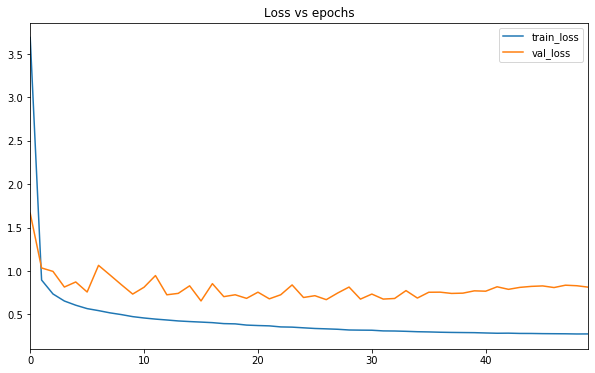

In [0]:
loss = history_df[['loss','val_loss']]
loss.columns = ['train_loss', 'val_loss']
loss.plot(figsize=(10, 6), title='Loss vs epochs')

#### **Let's plot training and validation accuracy vs epochs:**

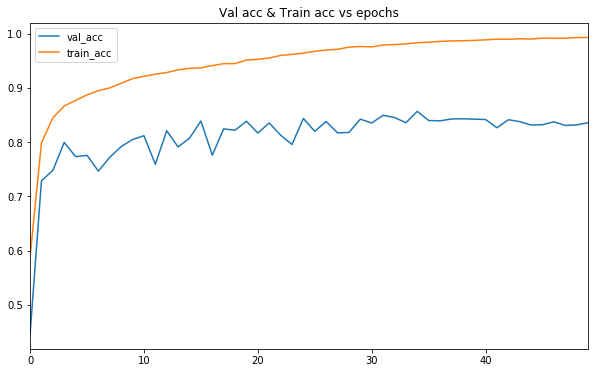

In [0]:
acc = history_df[['val_acc','acc']]
acc.columns = ['val_acc', 'train_acc']
acc.plot(figsize=(10, 6), title='Val acc & Train acc vs epochs')

#### **Let's plot learning rate vs epochs:**

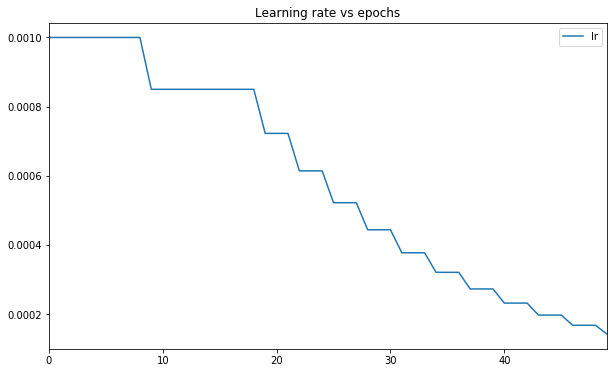

In [0]:
lr = history_df[['lr']]
lr.plot(figsize=(10, 6), title='Learning rate vs epochs')

#### **Let's evaluate the best model, on the validation set and compute relevant metrics:**

In [0]:
res_cnn.load_weights('base_model.h5')

In [0]:
## Balanced training and val
## Rotations every 45
## train_batch_size = 32

## 128x128 stride_60
## min_pos_pix_1250, mivalpos_1024
## no_dish_border on training images
## l2_reg = 0.1
## lr = 1e-3  
## opt_RMSprop, first_Kernel:3x3 (original ResNet is 7x7)

X, y_true = next(val_generator)
y_pred = res_cnn.predict(X)
for i in range(1, len(val_generator)):
  X, y = next(val_generator)
  y_true = np.vstack((y_true, y))
  y_pred = np.vstack((y_pred, res_cnn.predict(X)))

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

val_acc = accuracy_score(y_true, y_pred)
#roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
class_names = [k for k in val_generator.class_indices]
c_report = classification_report(y_true, y_pred, target_names=class_names)

print('\nval_acc:\n', val_acc)
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', c_report)


val_acc:
 0.8464972527472527

Confusion Matrix:
 [[363   0   1   0   0   0   0   0]
 [  2 352   3   0   0   0   7   0]
 [  0 101 254   0   0   0   9   0]
 [  0   0   1 299  62   0   2   0]
 [  0   0   0 213 151   0   0   0]
 [  0   0   1   4   0 359   0   0]
 [  0   8   0  33   0   0 323   0]
 [  0   0   0   0   0   0   0 364]]

Classification Report:
               precision    recall  f1-score   support

     C10_pos       0.99      1.00      1.00       364
      C1_pos       0.76      0.97      0.85       364
    C2-3_pos       0.98      0.70      0.81       364
    C4-7_pos       0.54      0.82      0.65       364
      C5_pos       0.71      0.41      0.52       364
      C6_pos       1.00      0.99      0.99       364
      C8_pos       0.95      0.89      0.92       364
      C9_pos       1.00      1.00      1.00       364

    accuracy                           0.85      2912
   macro avg       0.87      0.85      0.84      2912
weighted avg       0.87      0.85      0.84     


# <span style="color:red">*Conclusions and next steps:*</span>

#### **As we can see above in the confusion matrix, the model is having difficulty to differentiate between classes 'C1' and 'C2-3' and between classes 'C4-7' and 'C5'. 

#### As a next step, we will train a model specifically trained to differentiate 'C1' vs 'C2-3' vs 'all_other' classes. Similarly, we will train a model specifically trained to differentiate 'C4-7' vs 'C5' vs 'all_other' classes.

#### In addition, we will also train a model specifically trained to differentiate between positive bacterial colony patches (of any class) and negative patches (either petri-dish background, petri-dish border or white image background).

#### As a final step, we will combine our models and test them in test data to evaluate performance just once.